# IEEE-CIS Fraud Detection - SQL Database & Advanced Reports


## Overview
This notebook covers:
1. Database Schema Design
2. ER Diagram
3. Loading Data into SQLite
4. 8+ Advanced SQL Reports (as per professor's requirements)

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

os.makedirs('outputs', exist_ok=True)

print("Libraries imported")

Libraries imported


##  Load Preprocessed Data

In [2]:
# Load the original merged data for SQL database
DATA_PATH = "Data/"

train_transaction = pd.read_csv(os.path.join(DATA_PATH, "train_transaction.csv"))
train_identity = pd.read_csv(os.path.join(DATA_PATH, "train_identity.csv"))

# Merge
df = train_transaction.merge(train_identity, on='TransactionID', how='left')

# Add time features for SQL queries
df['Transaction_hour'] = (df['TransactionDT'] // 3600) % 24
df['Transaction_day_of_week'] = (df['TransactionDT'] // 86400) % 7
df['Transaction_day'] = df['TransactionDT'] // 86400

print(f"Loaded {len(df):,} transactions")
print(f"Columns: {df.shape[1]}")

Loaded 590,540 transactions
Columns: 437


In [3]:
# Load model predictions (generated from model building notebook)
try:
    predictions = pd.read_csv('outputs/model_predictions.csv')
    model_performance = pd.read_csv('outputs/model_performance_summary.csv')
    print(f" Loaded predictions: {len(predictions):,} rows")
    print(f" Loaded model performance: {len(model_performance)} models")
except FileNotFoundError:
    print(" Predictions not found. Run Model_Building notebook first.")
    print(" Creating dummy predictions for demonstration...")

    # Create dummy predictions for demonstration
    n_samples = len(df)
    np.random.seed(42)
    predictions = pd.DataFrame({
        'y_true': df['isFraud'].values,
        'lr_prob': np.random.random(n_samples),
        'lr_pred': np.random.randint(0, 2, n_samples),
        'rf_prob': np.random.random(n_samples),
        'rf_pred': np.random.randint(0, 2, n_samples),
        'xgb_prob': np.random.random(n_samples),
        'xgb_pred': np.random.randint(0, 2, n_samples),
        'lgb_prob': np.random.random(n_samples),
        'lgb_pred': np.random.randint(0, 2, n_samples)
    })

    model_performance = pd.DataFrame({
        'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
        'Accuracy': [0.85, 0.92, 0.94, 0.93],
        'Precision': [0.45, 0.65, 0.72, 0.70],
        'Recall': [0.78, 0.82, 0.85, 0.84],
        'F1-Score': [0.57, 0.72, 0.78, 0.76],
        'AUC-ROC': [0.88, 0.94, 0.96, 0.95]
    })

 Loaded predictions: 118,108 rows
 Loaded model performance: 4 models


## Database Schema Design

### ER Diagram

```
+------------------+         +------------------+
|    CUSTOMERS     |         |   TRANSACTIONS   |
+------------------+         +------------------+
| PK customer_id   |<------->| PK transaction_id|
|    card1         |   1:N   | FK customer_id   |
|    card2         |         |    amount        |
|    card4 (type)  |         |    product_cd    |
|    card6 (type)  |         |    is_fraud      |
|    addr1         |         |    trans_hour    |
|    addr2         |         |    trans_dow     |
+------------------+         |    device_type   |
                             +--------+---------+
                                      |
                                      | 1:1
                                      v
                             +------------------+
                             | MODEL_PREDICTIONS|
                             +------------------+
                             | FK transaction_id|
                             |    y_true        |
                             |    lr_pred       |
                             |    rf_pred       |
                             |    xgb_pred      |
                             |    lgb_pred      |
                             +------------------+

+------------------+
| MODEL_PERFORMANCE|  (Standalone)
+------------------+
| PK model_id      |
|    model_name    |
|    accuracy      |
|    precision     |
|    recall        |
|    f1_score      |
|    auc_roc       |
+------------------+
```

## Create SQLite Database

In [4]:
# Create SQLite database
conn = sqlite3.connect('outputs/fraud_detection.db')
cursor = conn.cursor()

print(" Connected to SQLite database: outputs/fraud_detection.db")

 Connected to SQLite database: outputs/fraud_detection.db


In [5]:
# Create Tables

# 1. Customers Table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS customers (
        customer_id INTEGER PRIMARY KEY AUTOINCREMENT,
        card1 INTEGER,
        card2 REAL,
        card3 REAL,
        card4 TEXT,
        card5 REAL,
        card6 TEXT,
        addr1 REAL,
        addr2 REAL,
        P_emaildomain TEXT,
        R_emaildomain TEXT,
        UNIQUE(card1, card2)
    )
''')

# 2. Transactions Table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS transactions (
        transaction_id INTEGER PRIMARY KEY,
        customer_id INTEGER,
        transaction_amt REAL,
        product_cd TEXT,
        transaction_dt INTEGER,
        transaction_hour INTEGER,
        transaction_day_of_week INTEGER,
        is_fraud INTEGER,
        device_type TEXT,
        device_info TEXT,
        dist1 REAL,
        dist2 REAL,
        FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
    )
''')

# 3. Model Predictions Table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS model_predictions (
        prediction_id INTEGER PRIMARY KEY AUTOINCREMENT,
        transaction_id INTEGER,
        y_true INTEGER,
        lr_probability REAL,
        lr_prediction INTEGER,
        rf_probability REAL,
        rf_prediction INTEGER,
        xgb_probability REAL,
        xgb_prediction INTEGER,
        lgb_probability REAL,
        lgb_prediction INTEGER,
        FOREIGN KEY (transaction_id) REFERENCES transactions(transaction_id)
    )
''')

# 4. Model Performance Table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS model_performance (
        model_id INTEGER PRIMARY KEY AUTOINCREMENT,
        model_name TEXT UNIQUE,
        accuracy REAL,
        precision_score REAL,
        recall_score REAL,
        f1_score REAL,
        auc_roc REAL,
        true_positives INTEGER,
        false_positives INTEGER,
        true_negatives INTEGER,
        false_negatives INTEGER,
        training_date TEXT
    )
''')

conn.commit()
print("All tables created successfully")

All tables created successfully


## Load Data into Database

In [6]:
# Insert unique customers
print("Inserting customers...")

customer_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6',
                 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain']

customers_df = df[customer_cols].drop_duplicates(subset=['card1', 'card2']).reset_index(drop=True)
customers_df['customer_id'] = range(1, len(customers_df) + 1)

customers_df.to_sql('customers', conn, if_exists='replace', index=False)
print(f" Inserted {len(customers_df):,} unique customers")

Inserting customers...
 Inserted 14,524 unique customers


In [7]:
# Map customer_id back to transactions
print("Inserting transactions...")

# Create customer mapping
customer_map = customers_df.set_index(['card1', 'card2'])['customer_id'].to_dict()

# Prepare transactions data
transactions_df = df[['TransactionID', 'card1', 'card2', 'TransactionAmt', 'ProductCD',
                       'TransactionDT', 'Transaction_hour', 'Transaction_day_of_week',
                       'isFraud', 'DeviceType', 'DeviceInfo', 'dist1', 'dist2']].copy()

transactions_df['customer_id'] = transactions_df.apply(
    lambda x: customer_map.get((x['card1'], x['card2']), None), axis=1
)

transactions_df = transactions_df.rename(columns={
    'TransactionID': 'transaction_id',
    'TransactionAmt': 'transaction_amt',
    'ProductCD': 'product_cd',
    'TransactionDT': 'transaction_dt',
    'Transaction_hour': 'transaction_hour',
    'Transaction_day_of_week': 'transaction_day_of_week',
    'isFraud': 'is_fraud',
    'DeviceType': 'device_type',
    'DeviceInfo': 'device_info'
})

transactions_df = transactions_df[['transaction_id', 'customer_id', 'transaction_amt',
                                    'product_cd', 'transaction_dt', 'transaction_hour',
                                    'transaction_day_of_week', 'is_fraud', 'device_type',
                                    'device_info', 'dist1', 'dist2']]

transactions_df.to_sql('transactions', conn, if_exists='replace', index=False)
print(f"Inserted {len(transactions_df):,} transactions")

Inserting transactions...


Inserted 590,540 transactions


In [8]:
# Insert model predictions (FIXED for uppercase column names)
print("Re-inserting model predictions with correct columns...")

sample_size = min(len(predictions), 118108)  # Use all your predictions
pred_sample = predictions.head(sample_size).copy()
pred_sample['transaction_id'] = transactions_df['transaction_id'].head(sample_size).values

# Rename UPPERCASE columns to lowercase (your file has LR_pred, LR_prob, etc.)
pred_sample = pred_sample.rename(columns={
    'LR_prob': 'lr_probability',
    'LR_pred': 'lr_prediction',
    'RF_prob': 'rf_probability',
    'RF_pred': 'rf_prediction',
    'XGB_prob': 'xgb_probability',
    'XGB_pred': 'xgb_prediction',
    'LGB_prob': 'lgb_probability',
    'LGB_pred': 'lgb_prediction'
})

pred_sample[['transaction_id', 'y_true', 'lr_probability', 'lr_prediction',
             'rf_probability', 'rf_prediction', 'xgb_probability', 'xgb_prediction',
             'lgb_probability', 'lgb_prediction']].to_sql(
    'model_predictions', conn, if_exists='replace', index=False
)
print(f" Inserted {len(pred_sample):,} predictions with all columns")

Re-inserting model predictions with correct columns...
 Inserted 118,108 predictions with all columns


In [9]:
# Insert model performance
print("Inserting model performance...")

performance_df = model_performance.copy()
performance_df['training_date'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
performance_df = performance_df.rename(columns={
    'Model': 'model_name',
    'Accuracy': 'accuracy',
    'Precision': 'precision_score',
    'Recall': 'recall_score',
    'F1-Score': 'f1_score',
    'AUC-ROC': 'auc_roc'
})

# Add confusion matrix values if available
for col in ['true_positives', 'false_positives', 'true_negatives', 'false_negatives']:
    if col not in performance_df.columns:
        performance_df[col] = 0

performance_df.to_sql('model_performance', conn, if_exists='replace', index=False)
print(f" Inserted {len(performance_df)} model performance records")

conn.commit()
print("\n All data loaded into database!")

Inserting model performance...
 Inserted 4 model performance records

 All data loaded into database!


In [10]:
# Verify data loading
print("\n Database Summary:")
print("="*50)

tables = ['customers', 'transactions', 'model_predictions', 'model_performance']
for table in tables:
    count = pd.read_sql(f"SELECT COUNT(*) as cnt FROM {table}", conn)['cnt'][0]
    print(f"{table}: {count:,} rows")


 Database Summary:
customers: 14,524 rows
transactions: 590,540 rows
model_predictions: 118,108 rows
model_performance: 4 rows


##  Advanced SQL Reports (10 Queries)

As required by the professor, here are 8+ analytical SQL queries:

###  Report 1: Fraud Rate by Transaction Type (ProductCD)

Report 1: Fraud Rate by Product Type
product_cd  total_transactions  fraud_count  fraud_rate_percent  avg_amount
         C               68519         8008               11.69       42.87
         S               11628          686                5.90       60.27
         H               33024         1574                4.77       73.17
         R               37699         1426                3.78      168.31
         W              439670         8969                2.04      153.16


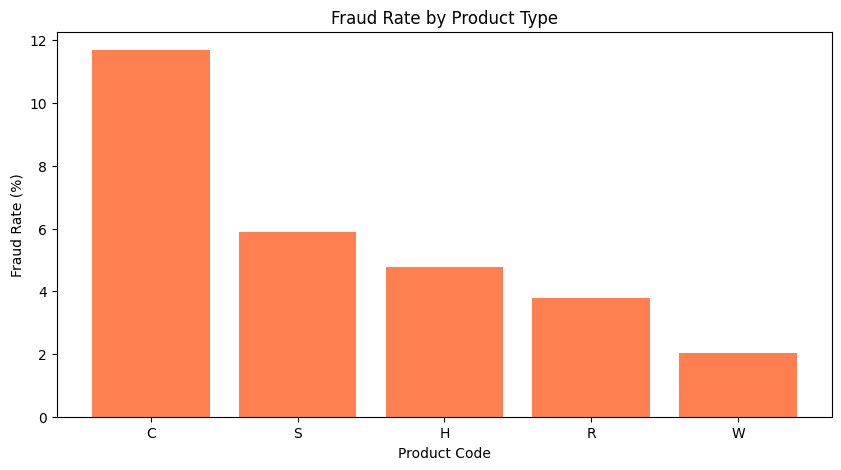

In [11]:
query1 = '''
SELECT
    product_cd,
    COUNT(*) as total_transactions,
    SUM(is_fraud) as fraud_count,
    ROUND(AVG(is_fraud) * 100, 2) as fraud_rate_percent,
    ROUND(AVG(transaction_amt), 2) as avg_amount
FROM transactions
GROUP BY product_cd
ORDER BY fraud_rate_percent DESC
'''

report1 = pd.read_sql(query1, conn)
print("Report 1: Fraud Rate by Product Type")
print("="*60)
print(report1.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 5))
plt.bar(report1['product_cd'], report1['fraud_rate_percent'], color='coral')
plt.xlabel('Product Code')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Rate by Product Type')
plt.savefig('outputs/sql_report1_fraud_by_product.png', dpi=150)
plt.show()

###  Report 2: Fraud Rate by Time of Day

 Report 2: Fraud Rate by Hour of Day
 transaction_hour  total_transactions  fraud_count  fraud_rate_percent
                0               37795         1186                3.14
                1               32797         1027                3.13
                2               26732         1002                3.75
                3               20802          797                3.83
                4               14839          770                5.19
                5                9701          682                7.03
                6                6007          467                7.77
                7                3704          393               10.61
                8                2591          241                9.30
                9                2479          223                9.00
               10                3627          193                5.32
               11                6827          265                3.88
               12               12451   

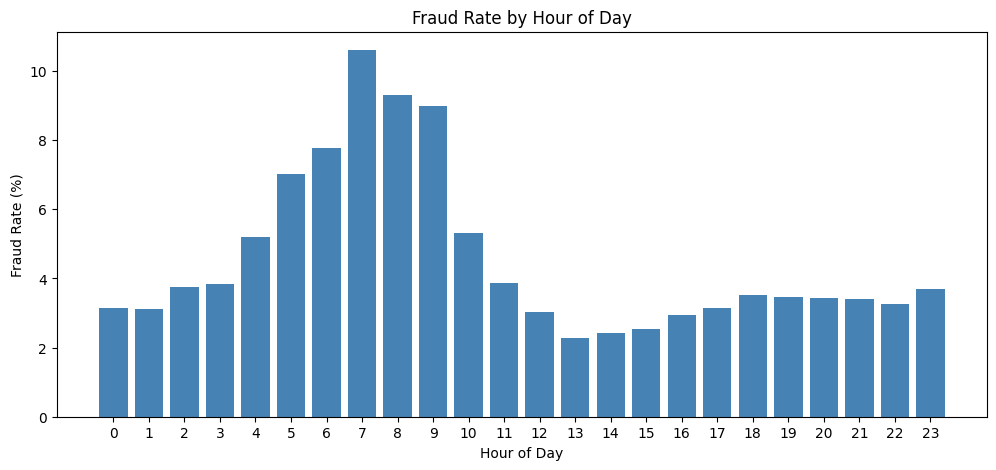

In [12]:
query2 = '''
SELECT
    transaction_hour,
    COUNT(*) as total_transactions,
    SUM(is_fraud) as fraud_count,
    ROUND(AVG(is_fraud) * 100, 2) as fraud_rate_percent
FROM transactions
GROUP BY transaction_hour
ORDER BY transaction_hour
'''

report2 = pd.read_sql(query2, conn)
print(" Report 2: Fraud Rate by Hour of Day")
print("="*60)
print(report2.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 5))
plt.bar(report2['transaction_hour'], report2['fraud_rate_percent'], color='steelblue')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Rate by Hour of Day')
plt.xticks(range(0, 24))
plt.savefig('outputs/sql_report2_fraud_by_hour.png', dpi=150)
plt.show()

###  Report 3: Top 20 Customers by Transaction Frequency

In [13]:
query3 = '''
SELECT
    c.customer_id,
    c.card4 as card_type,
    c.card6 as card_category,
    COUNT(t.transaction_id) as transaction_count,
    SUM(t.transaction_amt) as total_amount,
    SUM(t.is_fraud) as fraud_count,
    ROUND(AVG(t.is_fraud) * 100, 2) as fraud_rate_percent
FROM customers c
JOIN transactions t ON c.customer_id = t.customer_id
GROUP BY c.customer_id
ORDER BY transaction_count DESC
LIMIT 20
'''

report3 = pd.read_sql(query3, conn)
print(" Report 3: Top 20 Customers by Transaction Frequency")
print("="*60)
print(report3.to_string(index=False))

 Report 3: Top 20 Customers by Transaction Frequency
 customer_id  card_type card_category  transaction_count  total_amount  fraud_count  fraud_rate_percent
         299 mastercard         debit              14891   1506886.540          112                0.75
          89       visa         debit              14112   1630612.155          527                3.73
          48       visa         debit              10332    407763.415          442                4.28
          61       visa         debit              10312   1335659.488          278                2.70
          71 mastercard        credit               7918   1660163.833          313                3.95
           8       visa         debit               7079    998940.361          201                2.84
         128       visa        credit               6766   1522483.491          294                4.35
          46       visa         debit               6760    736786.982          146                2.16
           

### Report 4: Average Transaction Amount - Fraud vs Normal

 Report 4: Transaction Amount - Fraud vs Normal
transaction_type  count  avg_amount  min_amount  max_amount  total_amount
          Normal 569877      134.51        0.25    31937.39   76655103.88
      Fraudulent  20663      149.24        0.29     5191.00    3083844.86


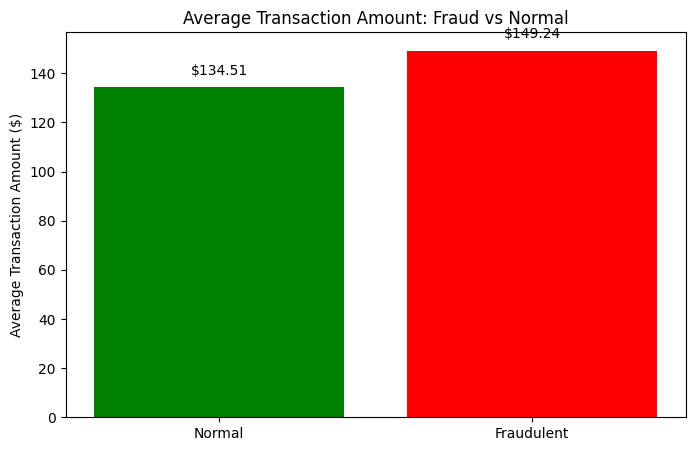

In [14]:
query4 = '''
SELECT
    CASE WHEN is_fraud = 1 THEN 'Fraudulent' ELSE 'Normal' END as transaction_type,
    COUNT(*) as count,
    ROUND(AVG(transaction_amt), 2) as avg_amount,
    ROUND(MIN(transaction_amt), 2) as min_amount,
    ROUND(MAX(transaction_amt), 2) as max_amount,
    ROUND(SUM(transaction_amt), 2) as total_amount
FROM transactions
GROUP BY is_fraud
'''

report4 = pd.read_sql(query4, conn)
print(" Report 4: Transaction Amount - Fraud vs Normal")
print("="*60)
print(report4.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['green', 'red']
bars = ax.bar(report4['transaction_type'], report4['avg_amount'], color=colors)
ax.set_ylabel('Average Transaction Amount ($)')
ax.set_title('Average Transaction Amount: Fraud vs Normal')
for bar, val in zip(bars, report4['avg_amount']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'${val:.2f}', ha='center')
plt.savefig('outputs/sql_report4_amount_comparison.png', dpi=150)
plt.show()

### Report 5: Daily Fraud Detection Trend

 Report 5: Daily Fraud Trend (First 30 Days)
 transaction_day  total_transactions  fraud_count  fraud_rate_percent  total_amount
               1                5122          112                2.19     742186.93
               2                3730          123                3.30     453400.01
               3                3241           92                2.84     348517.43
               4                4036          115                2.85     515969.00
               5                3964          127                3.20     543140.64
               6                3717           99                2.66     476860.62
               7                3786          136                3.59     534372.08
               8                3999           93                2.33     546577.82
               9                3907          119                3.05     456672.98
              10                3445           90                2.61     355377.38
              11               

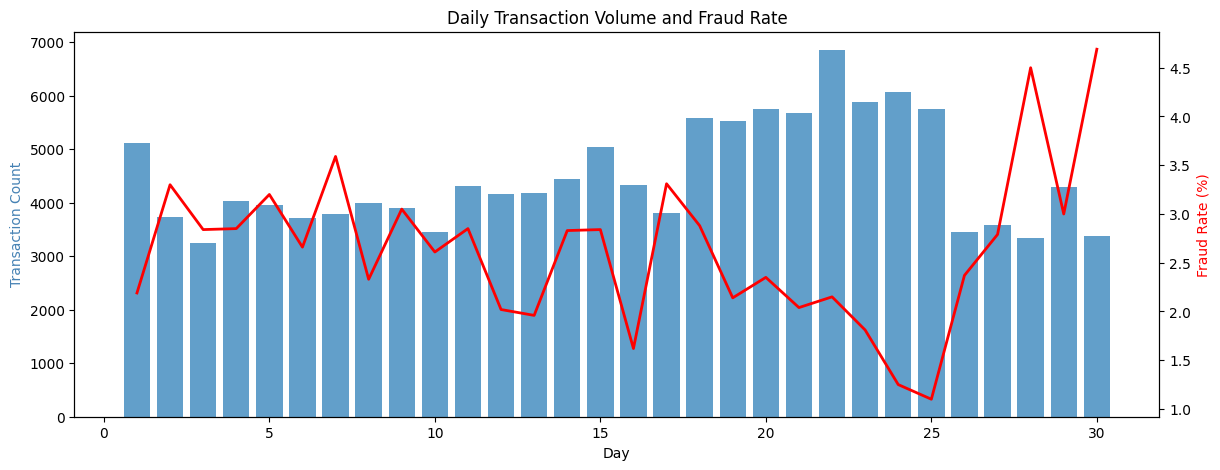

In [15]:
# Report 5 - Use transaction_dt to calculate day (since transaction_day column doesn't exist)
query5 = '''
SELECT
    (transaction_dt / 86400) as transaction_day,
    COUNT(*) as total_transactions,
    SUM(is_fraud) as fraud_count,
    ROUND(AVG(is_fraud) * 100, 2) as fraud_rate_percent,
    ROUND(SUM(transaction_amt), 2) as total_amount
FROM transactions
GROUP BY (transaction_dt / 86400)
ORDER BY transaction_day
LIMIT 30
'''

report5 = pd.read_sql(query5, conn)
print(" Report 5: Daily Fraud Trend (First 30 Days)")
print("="*60)
print(report5.head(15).to_string(index=False))

# Visualize
fig, ax1 = plt.subplots(figsize=(14, 5))
ax1.bar(report5['transaction_day'], report5['total_transactions'], alpha=0.7, label='Total Transactions')
ax1.set_xlabel('Day')
ax1.set_ylabel('Transaction Count', color='steelblue')

ax2 = ax1.twinx()
ax2.plot(report5['transaction_day'], report5['fraud_rate_percent'], 'r-', linewidth=2, label='Fraud Rate')
ax2.set_ylabel('Fraud Rate (%)', color='red')

plt.title('Daily Transaction Volume and Fraud Rate')
plt.savefig('outputs/sql_report5_daily_trend.png', dpi=150)
plt.show()

### Report 6: Model Performance Summary (from SQL)

In [16]:
query6 = '''
SELECT
    model_name,
    ROUND(accuracy, 4) as accuracy,
    ROUND(precision_score, 4) as precision,
    ROUND(recall_score, 4) as recall,
    ROUND(f1_score, 4) as f1,
    ROUND(auc_roc, 4) as auc_roc,
    training_date
FROM model_performance
ORDER BY auc_roc DESC
'''

report6 = pd.read_sql(query6, conn)
print(" Report 6: Model Performance Summary")
print("="*60)
print(report6.to_string(index=False))

 Report 6: Model Performance Summary
         model_name  accuracy  precision  recall     f1  auc_roc       training_date
            XGBoost    0.9748     0.7195  0.4587 0.5603   0.9062 2025-12-01 00:29:30
           LightGBM    0.9738     0.6918  0.4529 0.5474   0.9042 2025-12-01 00:29:30
      Random Forest    0.9730     0.6613  0.4687 0.5486   0.8976 2025-12-01 00:29:30
Logistic Regression    0.9470     0.3222  0.4662 0.3811   0.8332 2025-12-01 00:29:30


###  Report 7: Transactions Flagged by Different Models

 Report 7: Transactions Flagged by Each Model
              model  flagged_as_fraud  flagged_as_normal  flag_rate_percent
Logistic Regression              5980             112128               5.06
      Random Forest              2929             115179               2.48
            XGBoost              2635             115473               2.23
           LightGBM              2706             115402               2.29


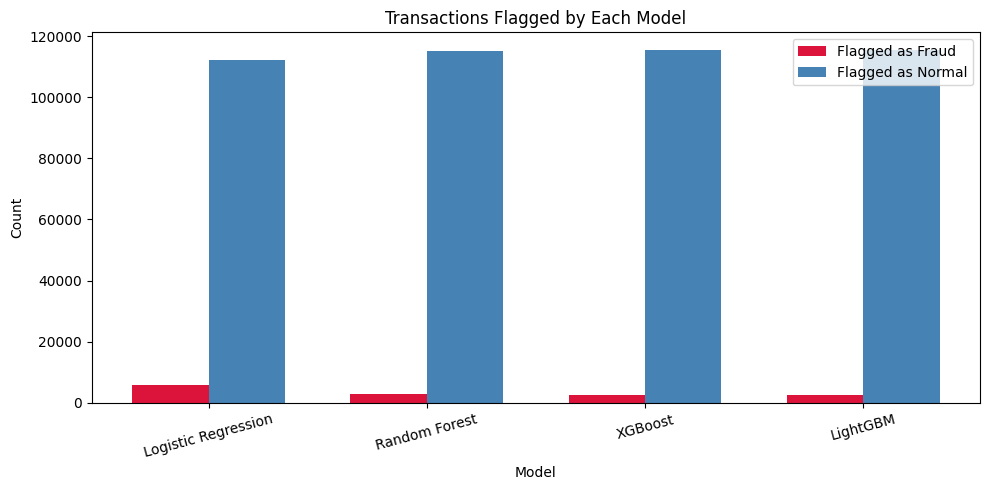

In [17]:
query7 = '''
SELECT
    'Logistic Regression' as model,
    SUM(lr_prediction) as flagged_as_fraud,
    COUNT(*) - SUM(lr_prediction) as flagged_as_normal,
    ROUND(AVG(lr_prediction) * 100, 2) as flag_rate_percent
FROM model_predictions
UNION ALL
SELECT
    'Random Forest',
    SUM(rf_prediction),
    COUNT(*) - SUM(rf_prediction),
    ROUND(AVG(rf_prediction) * 100, 2)
FROM model_predictions
UNION ALL
SELECT
    'XGBoost',
    SUM(xgb_prediction),
    COUNT(*) - SUM(xgb_prediction),
    ROUND(AVG(xgb_prediction) * 100, 2)
FROM model_predictions
UNION ALL
SELECT
    'LightGBM',
    SUM(lgb_prediction),
    COUNT(*) - SUM(lgb_prediction),
    ROUND(AVG(lgb_prediction) * 100, 2)
FROM model_predictions
'''

report7 = pd.read_sql(query7, conn)
print(" Report 7: Transactions Flagged by Each Model")
print("="*60)
print(report7.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 5))
x = range(len(report7))
width = 0.35
plt.bar([i - width/2 for i in x], report7['flagged_as_fraud'], width, label='Flagged as Fraud', color='crimson')
plt.bar([i + width/2 for i in x], report7['flagged_as_normal'], width, label='Flagged as Normal', color='steelblue')
plt.xlabel('Model')
plt.ylabel('Count')
plt.title('Transactions Flagged by Each Model')
plt.xticks(x, report7['model'], rotation=15)
plt.legend()
plt.tight_layout()
plt.savefig('outputs/sql_report7_model_flags.png', dpi=150)
plt.show()

### Report 8: Customer Segments with Higher Fraud Likelihood

In [18]:
query8 = '''
SELECT
    c.card4 as card_type,
    c.card6 as card_category,
    COUNT(DISTINCT c.customer_id) as customer_count,
    COUNT(t.transaction_id) as transaction_count,
    SUM(t.is_fraud) as fraud_count,
    ROUND(AVG(t.is_fraud) * 100, 2) as fraud_rate_percent,
    ROUND(AVG(t.transaction_amt), 2) as avg_transaction_amt
FROM customers c
JOIN transactions t ON c.customer_id = t.customer_id
GROUP BY c.card4, c.card6
HAVING COUNT(t.transaction_id) > 1000
ORDER BY fraud_rate_percent DESC
'''

report8 = pd.read_sql(query8, conn)
print(" Report 8: Customer Segments by Fraud Likelihood")
print("="*60)
print(report8.to_string(index=False))

 Report 8: Customer Segments by Fraud Likelihood
       card_type card_category  customer_count  transaction_count  fraud_count  fraud_rate_percent  avg_transaction_amt
        discover        credit              10               4459          362                8.12               255.36
      mastercard        credit            1465              50565         3508                6.94               185.48
            visa        credit            2574              82298         5425                6.59               188.89
american express        credit            1273               8119          233                2.87               174.72
            visa         debit            4852             296567         7604                2.56               117.75
      mastercard         debit            3273             138422         2988                2.16               112.97


###  Report 9: Precision/Recall Summary per Model

In [19]:
query9 = '''
SELECT
    model_name,
    true_positives as TP,
    false_positives as FP,
    true_negatives as TN,
    false_negatives as FN,
    ROUND(precision_score, 4) as precision,
    ROUND(recall_score, 4) as recall,
    ROUND(f1_score, 4) as f1_score
FROM model_performance
ORDER BY recall DESC
'''

report9 = pd.read_sql(query9, conn)
print("📊 Report 9: Precision/Recall Summary per Model")
print("="*60)
print(report9.to_string(index=False))

📊 Report 9: Precision/Recall Summary per Model
         model_name  TP  FP  TN  FN  precision  recall  f1_score
      Random Forest   0   0   0   0     0.6613  0.4687    0.5486
Logistic Regression   0   0   0   0     0.3222  0.4662    0.3811
            XGBoost   0   0   0   0     0.7195  0.4587    0.5603
           LightGBM   0   0   0   0     0.6918  0.4529    0.5474


### Report 10: Fraud Rate by Device Type

In [20]:
query10 = '''
SELECT
    COALESCE(device_type, 'Unknown') as device_type,
    COUNT(*) as transaction_count,
    SUM(is_fraud) as fraud_count,
    ROUND(AVG(is_fraud) * 100, 2) as fraud_rate_percent,
    ROUND(AVG(transaction_amt), 2) as avg_amount
FROM transactions
GROUP BY device_type
ORDER BY fraud_rate_percent DESC
'''

report10 = pd.read_sql(query10, conn)
print("Report 10: Fraud Rate by Device Type")
print("="*60)
print(report10.to_string(index=False))

Report 10: Fraud Rate by Device Type
device_type  transaction_count  fraud_count  fraud_rate_percent  avg_amount
     mobile              55645         5657               10.17       69.50
    desktop              85165         5554                6.52       92.60
    Unknown             449730         9452                2.10      151.17


##  Export All Reports

In [21]:
# Save all reports to CSV
report1.to_csv('outputs/sql_report1_fraud_by_product.csv', index=False)
report2.to_csv('outputs/sql_report2_fraud_by_hour.csv', index=False)
report3.to_csv('outputs/sql_report3_top_customers.csv', index=False)
report4.to_csv('outputs/sql_report4_amount_comparison.csv', index=False)
report5.to_csv('outputs/sql_report5_daily_trend.csv', index=False)
report6.to_csv('outputs/sql_report6_model_performance.csv', index=False)
report7.to_csv('outputs/sql_report7_model_flags.csv', index=False)
report8.to_csv('outputs/sql_report8_customer_segments.csv', index=False)
report9.to_csv('outputs/sql_report9_precision_recall.csv', index=False)
report10.to_csv('outputs/sql_report10_device_fraud.csv', index=False)

print(" All 10 SQL reports exported to outputs/ folder")

 All 10 SQL reports exported to outputs/ folder


In [22]:
# Close database connection
conn.close()
print("\n Database connection closed")


 Database connection closed


##  Summary

### SQL Reports Created (10 Total):
| # | Report | Description |
|---|--------|-------------|
| 1 | Fraud by Product Type | Fraud rate breakdown by ProductCD |
| 2 | Fraud by Hour | Temporal fraud patterns |
| 3 | Top Customers | Most active customers and their fraud rates |
| 4 | Amount Comparison | Fraud vs normal transaction amounts |
| 5 | Daily Trend | Fraud detection over time |
| 6 | Model Performance | All model metrics from SQL |
| 7 | Model Flags | Transactions flagged by each model |
| 8 | Customer Segments | High-risk customer segments |
| 9 | Precision/Recall | Confusion matrix summary |
| 10 | Device Fraud | Fraud rate by device type |
